[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-1-dc4ac5d94437>:80: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


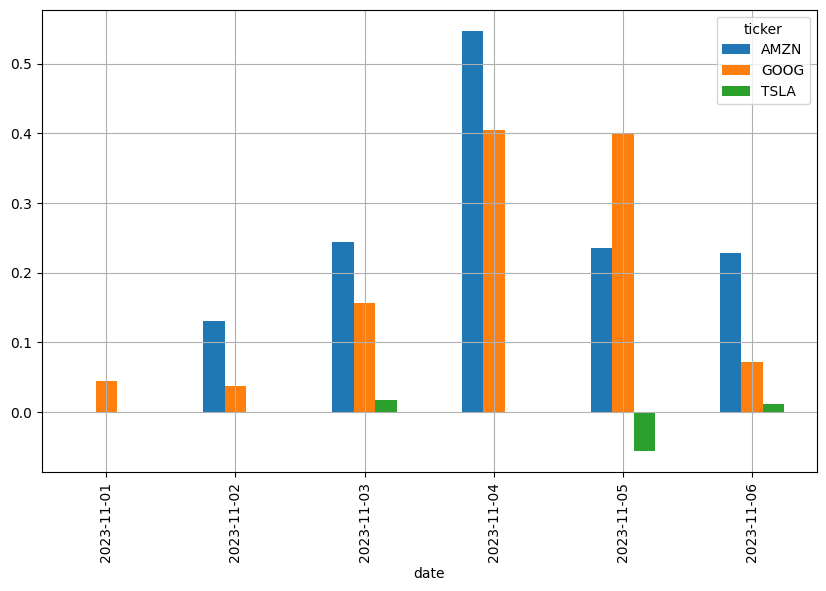

In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'})
    response = urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table
# Read one single day of headlines for ‘AMZN’
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into ‘amzn_tr’
amzn_tr = amzn.findAll('tr')
for i, table_row in enumerate(amzn_tr):
  # Read the text of the element ‘a’ into ‘link_text’
  a_text = table_row.a.text
  # Read the text of the element ‘td’ into ‘data_text’
  td_text = table_row.td.text
  # Print the contents of ‘link_text’ and ‘data_text’
  """print(a_text)
  print(td_text)"""
  # Exit after printing 4 rows of data
  if i == 3:
    break
parsed_news = []
# Iterate through the news
for file_name, news_table in news_tables.items():
  # Iterate through all tr tags in 'news_table'
  for x in news_table.findAll('tr'):
    if x.a!=None:
      # read the text from each tr tag into text
      # get text from a only
      text = x.a.text
      # splite text in the td tag into a list
      date_scrape = x.td.text.split()
      # if the length of 'date_scrape' is 1, load 'time' as the only element
      if len(date_scrape) == 1:
        time = date_scrape[0]
      else:
        date = date_scrape[0]
        time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'
        ticker = file_name.split('_')[0]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
      if date!="Today":
        parsed_news.append([ticker, date, time, text])
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()
# Set column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()
# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')
# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date
parsed_and_scored_news.head()
plt.rcParams['figure.figsize'] = [10, 6]
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [2]:
parsed_and_scored_news

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2023-11-06,06:03PM,15 Biggest Renewable Energy Companies in Europe,0.000,0.741,0.259,0.2732
1,AMZN,2023-11-06,05:26PM,Microsoft-Backed ChatGPT Maker OpenAI Unveils ...,0.000,1.000,0.000,0.0000
2,AMZN,2023-11-06,04:20PM,"Amazon hosting Black Friday, Cyber Monday sale...",0.000,0.841,0.159,0.1779
3,AMZN,2023-11-06,04:06PM,Market Today: Tech Stocks Lead the Way as S&P ...,0.000,1.000,0.000,0.0000
4,AMZN,2023-11-06,04:05PM,Magnificent Seven Stocks Ignite New Rally And...,0.000,0.698,0.302,0.5994
...,...,...,...,...,...,...,...,...
241,GOOG,2023-11-02,05:59AM,You Might Be Shocked to Learn Where the S&P 50...,0.243,0.757,0.000,-0.6647
242,GOOG,2023-11-01,11:14PM,Q3 2023 Match Group Inc Earnings Call,0.000,1.000,0.000,0.0000
243,GOOG,2023-11-01,10:47PM,Rule Breaker Investing: 9 Foolish Truths,0.266,0.380,0.354,0.1779
244,GOOG,2023-11-01,08:37PM,"Google rolls out promotional tools, including ...",0.000,1.000,0.000,0.0000


from matplotlib import pyplot as plt
parsed_and_scored_news['neg'].plot(kind='hist', bins=20, title='neg')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news['neu'].plot(kind='hist', bins=20, title='neu')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news['pos'].plot(kind='hist', bins=20, title='pos')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news['compound'].plot(kind='hist', bins=20, title='compound')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
parsed_and_scored_news.groupby('ticker').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
parsed_and_scored_news.groupby('date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news.plot(kind='scatter', x='neg', y='neu', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news.plot(kind='scatter', x='neu', y='pos', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news.plot(kind='scatter', x='pos', y='compound', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['neg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = parsed_and_scored_news.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ticker')):
  _plot_series(series, series_name, i)
  fig.legend(title='ticker', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('neg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['neg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = parsed_and_scored_news.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('neg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['neu']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = parsed_and_scored_news.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ticker')):
  _plot_series(series, series_name, i)
  fig.legend(title='ticker', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('neu')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['neu']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = parsed_and_scored_news.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('neu')

from matplotlib import pyplot as plt
parsed_and_scored_news['neg'].plot(kind='line', figsize=(8, 4), title='neg')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news['neu'].plot(kind='line', figsize=(8, 4), title='neu')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news['pos'].plot(kind='line', figsize=(8, 4), title='pos')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
parsed_and_scored_news['compound'].plot(kind='line', figsize=(8, 4), title='compound')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['date'].value_counts()
    for x_label, grp in parsed_and_scored_news.groupby('ticker')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ticker')
_ = plt.ylabel('date')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(parsed_and_scored_news['ticker'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(parsed_and_scored_news, x='neg', y='ticker', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(parsed_and_scored_news['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(parsed_and_scored_news, x='neg', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(parsed_and_scored_news['ticker'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(parsed_and_scored_news, x='neu', y='ticker', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(parsed_and_scored_news['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(parsed_and_scored_news, x='neu', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)